In [28]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [29]:
# Create list of all targets (minus background noise)
dataset_path = 'speech_command_dataset'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['nine', 'happy', 'tree', 'backward', 'bed', 'learn', 'one', 'five', 'Images', 'off', 'down', 'forward', 'sheila', 'cat', 'dog', 'up', 'bird', 'follow', 'six', 'eight', 'zero', 'three', 'right', 'go', 'left', 'no', 'wow', 'stop', 'on', 'yes', 'four', 'visual', 'marvin', 'seven', 'two', 'house']


In [30]:
# Settings
feature_sets_path = 'feature_sets_directory'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'hey_rodney_model.h5'
wake_word = 'hey-rodney'

In [32]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [33]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [34]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77458, 16, 16)
(9675, 16, 16)
(9723, 16, 16)


In [35]:
# Peek at labels
print(y_val)

[ 0. 25. 21. ... 24. 27.  0.]


In [36]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [37]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. ... 0. 0. 0.]


In [38]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.01984496124031008
0.9801550387596899


In [39]:
# View the dimensions of our input data
print(x_train.shape)

(77458, 16, 16)


In [40]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77458, 16, 16, 1)
(9675, 16, 16, 1)
(9723, 16, 16, 1)


In [41]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [42]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [43]:
# Display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

In [44]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [45]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
775/775 [==============================] - 7s 7ms/step - loss: 0.0809 - acc: 0.9800 - val_loss: 0.0597 - val_acc: 0.9808
Epoch 2/30
775/775 [==============================] - 5s 7ms/step - loss: 0.0529 - acc: 0.9849 - val_loss: 0.0391 - val_acc: 0.9890
Epoch 3/30
775/775 [==============================] - 6s 7ms/step - loss: 0.0435 - acc: 0.9880 - val_loss: 0.0565 - val_acc: 0.9844
Epoch 4/30
775/775 [==============================] - 6s 7ms/step - loss: 0.0407 - acc: 0.9895 - val_loss: 0.0530 - val_acc: 0.9889
Epoch 5/30
775/775 [==============================] - 6s 7ms/step - loss: 0.0407 - acc: 0.9896 - val_loss: 0.0412 - val_acc: 0.9894
Epoch 6/30
775/775 [==============================] - 6s 7ms/step - loss: 0.0400 - acc: 0.9901 - val_loss: 0.0442 - val_acc: 0.9903
Epoch 7/30
775/775 [==============================] - 6s 7ms/step - loss: 0.0419 - acc: 0.9904 - val_loss: 0.0488 - val_acc: 0.9879
Epoch 8/30
775/775 [==============================] - 6s 7ms/step - loss: 0.

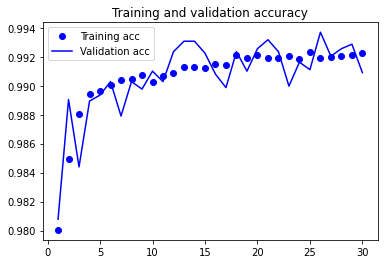

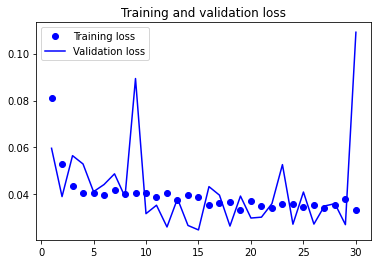

In [46]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
# Save the model as a file
models.save_model(model, model_filename)

In [48]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

218
398
413
462
468
491
563
601
631
685
740
865
893
967
977
1002
1004
1157
1173
1231
1279
1282
1322
1357
1433
1437
1524
1570
1610
1701
1736
1889
1948
2096
2097
2098
2154
2188
2419
2436
2450
2475
2479
2490
2491
2530
2625
2648
2705
2710
2730
2893
2904
2951
2986
2993
3060
3085
3176
3210
3274
3474
3522
3551
3559
3678
3684
3745
3846
3854
3919
3922
3967
4054
4191
4216
4332
4496
4530
4586
4681
4693
4715
4764
4770
4858
4862
4892
4901
5021
5072
5073
5144
5234
5279
5288
5325
5374
5430
5575
5579
5675
5686
5825
5925
5982
6008
6026
6177
6202
6248
6276
6303
6457
6554
6559
6595
6644
6761
6821
6856
6864
6871
6898
7035
7114
7235
7288
7292
7299
7422
7515
7543
7545
7640
7660
7669
7688
7697
7711
7807
7843
7848
8029
8107
8162
8245
8306
8524
8536
8571
8627
8632
8644
8709
8729
8770
8778
8822
8832
8946
8980
9016
9050
9089
9108
9115
9179
9223
9295
9333
9342
9345
9371
9422
9449
9495
9545
9548
9557
9611


In [49]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 0.0  Prediction: [[0.00019279]]
Answer: 0.0  Prediction: [[1.4243692e-08]]
Answer: 0.0  Prediction: [[2.1966839e-08]]
Answer: 0.0  Prediction: [[2.627506e-07]]
Answer: 0.0  Prediction: [[3.358046e-07]]
Answer: 0.0  Prediction: [[5.039134e-13]]
Answer: 0.0  Prediction: [[2.7192726e-11]]
Answer: 0.0  Prediction: [[4.9616127e-14]]
Answer: 0.0  Prediction: [[9.5186704e-20]]
Answer: 0.0  Prediction: [[2.6716914e-15]]


In [50]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

304/304 [==============================] - 0s 978us/step - loss: 0.1305 - acc: 0.9906


[0.1304587423801422, 0.9906407594680786]